In [673]:
import pandas as pd
import numpy as np
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate

from math import log as log
import os

In [674]:
!pip freeze > requirements.txt

In [703]:
def vis_cross_val_score(d_name_metric, d_vec, d_value_metric, font_scale):
    num_folds = len(d_vec['train_score'])
    avg_metric_train, std_metric_train = d_vec['train_score'].mean(), d_vec['train_score'].std()
    avg_metric_test, std_metric_test = d_vec['test_score'].mean(), d_vec['test_score'].std()

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)

    plt.figure(figsize=(12, 6))
    plt.plot(d_vec['train_score'], label='тренировочные значения', marker='.', color='darkblue')
    plt.plot([0, num_folds - 1], [avg_metric_train, avg_metric_train], color='blue',
             label='среднее трен. значений ', marker='.', lw=2, ls='--')

    plt.plot(d_vec['test_score'], label='тестовые значения', marker='.', color='red')
    plt.plot([0, num_folds - 1], [avg_metric_test, avg_metric_test], color='lightcoral',
             label='среднее тест. значений ', marker='.', lw=2, ls='--')

    plt.plot([0, num_folds - 1], [d_value_metric, d_value_metric], color='grey',
             label='значение метрики до CV', marker='.', lw=3)

    # plt.xlim([1, num_folds])
    y_max = max(avg_metric_train, avg_metric_test) + 1.5 * max(std_metric_train, std_metric_test)
    y_min = min(avg_metric_train, avg_metric_test) - 3 * max(std_metric_train, std_metric_test)
    plt.ylim([y_min, y_max])
    plt.xlabel('номер фолда', fontsize=15, color=color_text)
    plt.ylabel(d_name_metric, fontsize=15, color=color_text)
    plt.title(f'Кросс-валидация по метрике {d_name_metric} на {num_folds} фолдах',
              color=color_text, fontsize=17)
    plt.legend(loc="lower right", fontsize=11)
    y_min_text = y_min + 0.5 * max(std_metric_train, std_metric_test)
    plt.text(0, y_min_text,
             f'{d_name_metric} на трейне = {round(avg_metric_train, 3)} +/- '
             f'{round(std_metric_train, 3)} \n{d_name_metric} на тесте    = {round(avg_metric_test, 3)} +/- '
             f'{round(std_metric_test, 3)} \n{d_name_metric} до CV        = {round(d_value_metric, 3)}',
             fontsize=15)
    plt.show()
    return


## Загружаем данные

In [675]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [676]:
print('Размер тренировочного датасета: ', train.shape)
display(train.head(3))
print('Размер тестового датасета: ', test.shape)
display(test.head(3))

Размер тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


Размер тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


In [677]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

## Предварительный анализ данных

In [678]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


Резюме по предварительному анализу: в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 20 переменных, из них 1 - временной ряд, 6 бинарных, 7 категориальных и 8 числовых. Всего пропусков 272 (0.4%), все пропуски в переменной education. client_id уникальный числовой признак, который не несет полезной нагрузки. В бинарных признаках наше целевая переменная default и искуственно добавленный признак тренировочной части датасета Train

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

df.default.hist()

# Посмотрим на каспределение призника 'education' с пропусками
df['education'].value_counts().plot.bar()

In [679]:
# Всего пропусков 272 (0.4%). Заполним наиболее часто встречающимся значением
df.education.fillna(df.education.describe().top, inplace = True)

In [680]:
# Преобразуем формат признака
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [681]:
# Выясним разброс дат
df.app_date.min(), df.app_date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [682]:
print(df.query('Train==1').app_date.min(), df.query('Train==1').app_date.max(),
      df.query('Train==0').app_date.min(), df.query('Train==0').app_date.max())

2014-01-01 00:00:00 2014-04-30 00:00:00 2014-01-01 00:00:00 2014-04-30 00:00:00


In [683]:
# Вводим новый признак - номер дня
df['days'] = (df.app_date - df.app_date.min()).dt.days.astype('int')

In [684]:
for i in range(0,df.shape[0]):
    if df.car_type.iloc[i]=='Y':
        df.car.iloc[i]='In'

C:\IT\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [685]:
#бинарный переменные
bin_cols = ['sex', 'good_work', 'foreign_passport']
#категориальные переменные
cat_cols = ['education', 'car', 'home_address', 'work_address','region_rating', 'sna', 'first_time']
#числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income','score_bki', 'days']
# временной ряд 
time_cols = ['app_date']

In [686]:
df.corr().days

client_id          0.999581
age                0.015831
decline_app_cnt   -0.021489
good_work          0.003295
score_bki         -0.061969
bki_request_cnt   -0.027610
region_rating      0.004645
home_address       0.162314
work_address       0.161763
income            -0.002364
sna               -0.001476
first_time         0.016491
default           -0.039372
Train              0.002842
days               1.000000
Name: days, dtype: float64

 Days почти полностью коррелирует с client_id. Это говорит о том, что номер в базе присваивался по мере обращения клиентов

for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'Train', y = i, data = df)
    plt.title(i)
    plt.show()

for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'default', y = i, data = df.query('Train==1'))
    plt.title(i)
    plt.show()
    

sns.pairplot(df.query('Train==1')[num_cols])

sns.pairplot(df.query('Train==0')[num_cols])

### Матрицы корреляции и оценка значимости параметров

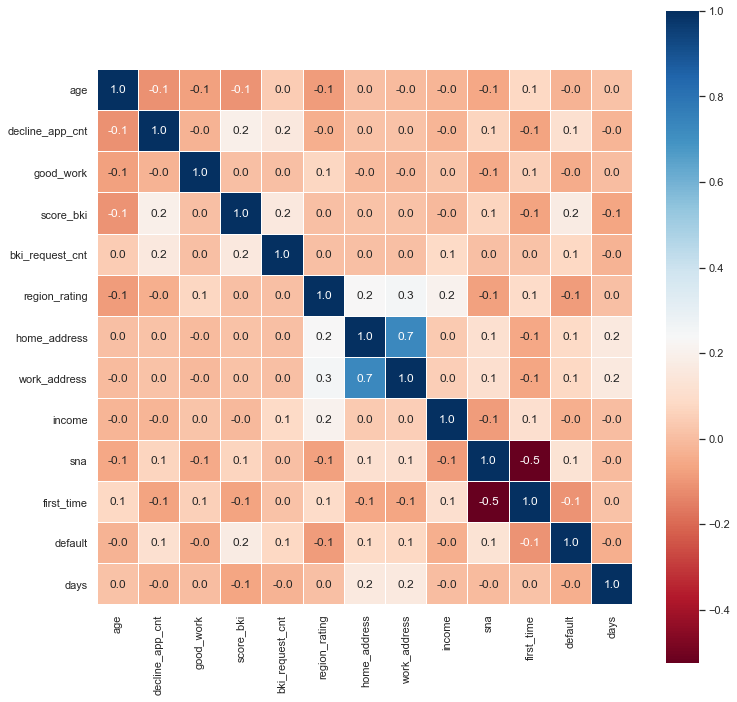

In [687]:
sns.set(font_scale = 1)
plt.subplots(figsize = (12,12))
sns.heatmap(df.query('Train==1').drop(['Train', 'client_id'], axis = 1).corr(),square = True, annot = True, fmt = '.1f', linewidths=0.1, cmap="RdBu")

# Преобразование данных

In [688]:
# Прологарифмируем числовые признаки, так как у всех имеем много 0 значений и длинный правый хвост. 
# Кроме параметра score_bki и days

for i in num_cols[:-2]:
    df[i] = np.log(df[i]+1)


for i in num_cols:
    plt.figure()
    sns.distplot(df[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

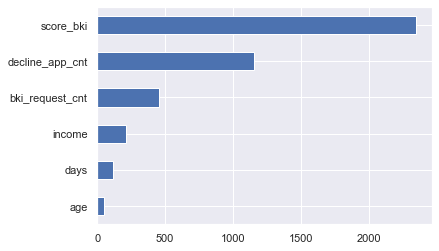

In [689]:
imp_num = Series(f_classif(df.query('Train == 1')[num_cols], df.query('Train == 1')['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

for i in cat_cols:
    plt.figure()
    sns.boxplot(x = i, y = 'income', data = df.query('Train==1'), hue = 'default')
    plt.title(i)
    plt.show()

for i in cat_cols:
    plt.figure()
    sns.boxplot(x = i, y = 'score_bki', data = df, hue = 'Train')
    plt.title(i)
    plt.show()

In [690]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days
0,25905,2014-02-01,SCH,1,4.143135,In,Y,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,0,0.0,1,31
1,63161,2014-03-12,SCH,0,4.094345,N,N,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,0,0.0,1,70
2,25887,2014-02-01,SCH,1,3.258097,Y,N,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,1,0.0,1,31
3,16222,2014-01-23,SCH,0,3.988984,N,N,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,0,0.0,1,22
4,101655,2014-04-18,GRD,1,3.891820,N,N,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,1,0.0,1,107


In [693]:
df['education'] = label_encoder.fit_transform(df['education'])
df['car'] = label_encoder.fit_transform(df['car'])    

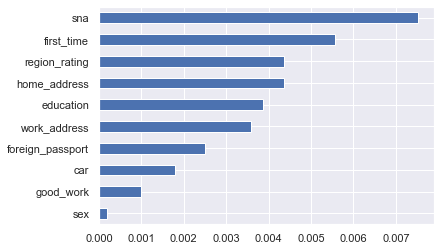

In [694]:
imp_cat = Series(mutual_info_classif(df.query('Train == 1')[bin_cols + cat_cols], df.query('Train == 1')['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [695]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df.query('Train == 1')[cat_cols].values)

In [696]:
X_cat.shape

(73799, 29)

In [697]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df.query('Train == 1')[num_cols].values)

# Создание модели

In [698]:
# Объединяем

X = np.hstack([X_num, df.query('Train == 1')[bin_cols].values, X_cat])
Y = df.query('Train == 1')['default'].values

In [699]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


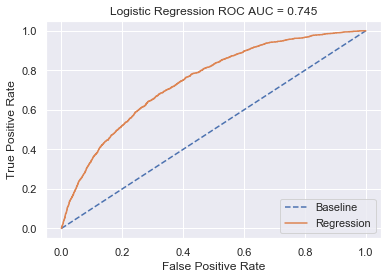

accuracy_score  0.8747967479674796
precision_score 0.39805825242718446
recall_score    0.022441160372194856
f1_score        0.04248704663212436


In [661]:
model_0 = LogisticRegression()
model_0.fit(X_train, y_train)

probs = model_0.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Y_pred = model_0.predict(X_test)
print('accuracy_score ', accuracy_score(y_test, Y_pred))
print('precision_score', precision_score(y_test,Y_pred))
print('recall_score   ', recall_score(y_test,Y_pred))
print('f1_score       ', f1_score(y_test,Y_pred))

In [627]:
# Добавим 
iter_ = 50
epsilon_stop = 1e-3

# Создадим гиперпараметры
hyperparameters = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

clf.fit(X_train, y_train)
model_1 = clf.best_estimator_

# View best hyperparameters
print('Лучшее Penalty:', model_1.get_params()['penalty'])
print('Лучшее C:', model_1.get_params()['C'])

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters

C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Convergenc

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:94

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lea

Лучшее Penalty: l2
Лучшее C: 1.0


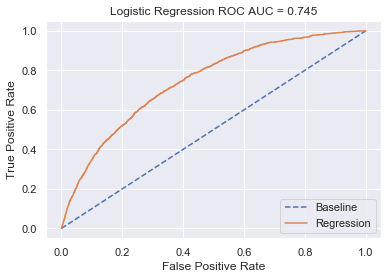

model_1
accuracy_score  0.8745934959349594
precision_score 0.38461538461538464
recall_score    0.021893814997263273
f1_score        0.04142931123770067


In [628]:
probs = model_1.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Y_pred = model_1.predict(X_test)
print('model_1')
print('accuracy_score ', accuracy_score(y_test, Y_pred))
print('precision_score', precision_score(y_test,Y_pred))
print('recall_score   ', recall_score(y_test,Y_pred))
print('f1_score       ', f1_score(y_test,Y_pred))

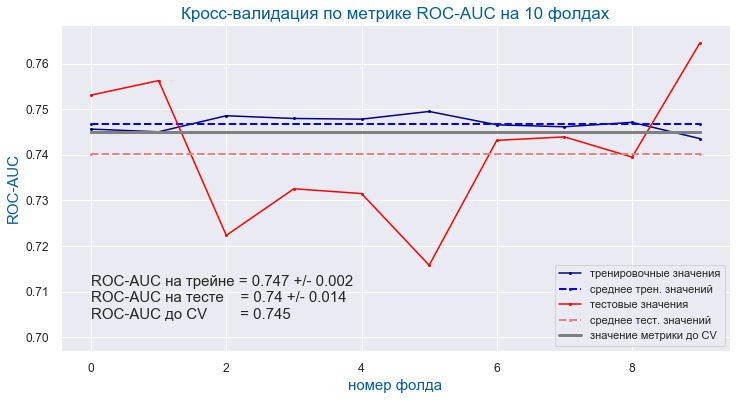

In [706]:
temp_vec = cross_validate(model_1, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);
vis_cross_val_score('ROC-AUC', temp_vec, 0.745, 1.1)

 После использования GreedSerch метрики не изменились. Мы видим что у нас очень низкие значения метрики f1 и recall.

 ### Модель 2 

Настроим GreedSerch по метрике f1 и recall

In [700]:
# Добавим 
iter_ = 50
epsilon_stop = 1e-3

# Создадим гиперпараметры
hyperparameters = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression()

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, scoring='f1', cv=5, verbose=0)

clf.fit(X_train, y_train)
model_2 = clf.best_estimator_

# View best hyperparameters
print('Лучшее Penalty:', model_2.get_params()['penalty'])
#print('Лучшее C:', model_2.get_params()['C'])

C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: E

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", 

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_wa

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_wa

Лучшее Penalty: l2


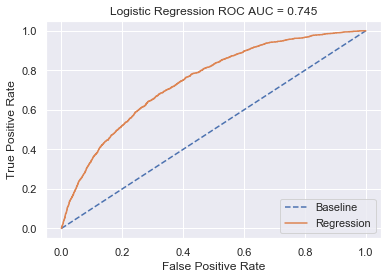

model_2
accuracy_score  0.6711382113821138
precision_score 0.22675573208160318
recall_score    0.6874657909140668
f1_score        0.34102633722508824


In [701]:

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Y_pred = model_2.predict(X_test)
print('model_2')
print('accuracy_score ', accuracy_score(y_test, Y_pred))
print('precision_score', precision_score(y_test,Y_pred))
print('recall_score   ', recall_score(y_test,Y_pred))
print('f1_score       ', f1_score(y_test,Y_pred))
probs = model_2.predict_proba(X_test)
probs = probs[:,1]

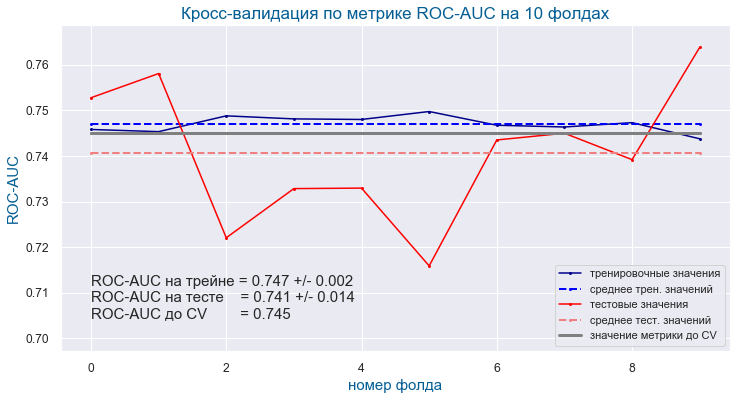

In [705]:
temp_vec = cross_validate(model_2, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);
vis_cross_val_score('ROC-AUC', temp_vec, 0.745, 1.1)

Для recall

In [656]:
# Добавим типы регуляризации
iter_ = 50
epsilon_stop = 1e-3

# Создадим гиперпараметры
hyperparameters = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression()

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, scoring='recall', cv=5, verbose=0)

clf.fit(X_train, y_train)
model_3 = clf.best_estimator_

# View best hyperparameters
print('Лучшее Penalty:', model_3.get_params()['penalty'])
print('Лучшее C:', model_3.get_params()['C'])

C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFailedWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: E

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", 

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_wa

C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_wa

Лучшее Penalty: l2
Лучшее C: 1.0


C:\IT\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


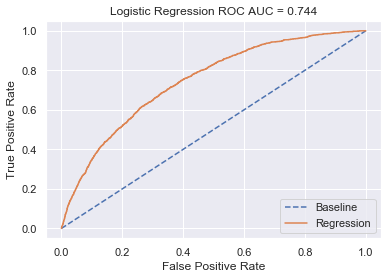

model_3
accuracy_score  0.6710027100271003
precision_score 0.2265751940783535
recall_score    0.6869184455391352
f1_score        0.3407548194406734


In [657]:

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Y_pred = model_3.predict(X_test)
print('model_3')
print('accuracy_score ', accuracy_score(y_test, Y_pred))
print('precision_score', precision_score(y_test,Y_pred))
print('recall_score   ', recall_score(y_test,Y_pred))
print('f1_score       ', f1_score(y_test,Y_pred))
probs = model_3.predict_proba(X_test)
probs = probs[:,1]

по Roc-AUC

## Проверяем на тесте

In [314]:
X_t_cat = OneHotEncoder(sparse = False).fit_transform(df.query('Train == 0')[cat_cols].values)
X_t_num = StandardScaler().fit_transform(df.query('Train == 0')[num_cols].values)

In [315]:
# Объединяем

X_t = np.hstack([X_t_num, df.query('Train == 0')[bin_cols].values, X_t_cat])

In [316]:
X_train, X_test = train_test_split(X_t, test_size=0.20, random_state=42)

In [317]:
Y_pred = model_3.predict(X_t)

In [318]:
Y_pred.shape

(36349,)

In [319]:
submit = pd.DataFrame(test.client_id)
submit['default']=Y_pred
submit.to_csv('submission.csv', index=False)

In [112]:
submit.head(5)

,client_id,default
0,74835,0.0
1,17527,0.0
2,75683,0.0
3,26883,0.0
4,28862,0.0


In [563]:
X_num.shape, len(bin_cols), X_cat.shape

((73799, 5), 5, (73799, 146))

In [562]:
model_4.coef_.shape

(1, 156)

In [565]:
len(df.days.value_counts())

120

In [570]:
feach = num_cols+bin_cols+cat_cols[:26]

In [567]:
feach_df = pd.DataFrame()

In [574]:
len(feach)

17

In [577]:
feach

['age',
 'decline_app_cnt',
 'bki_request_cnt',
 'income',
 'score_bki',
 'sex',
 'car',
 'car_type',
 'good_work',
 'foreign_passport',
 'education',
 'home_address',
 'work_address',
 'region_rating',
 'sna',
 'first_time',
 'days']

In [590]:
len(model_4.coef_[model_4.coef_>0])

76

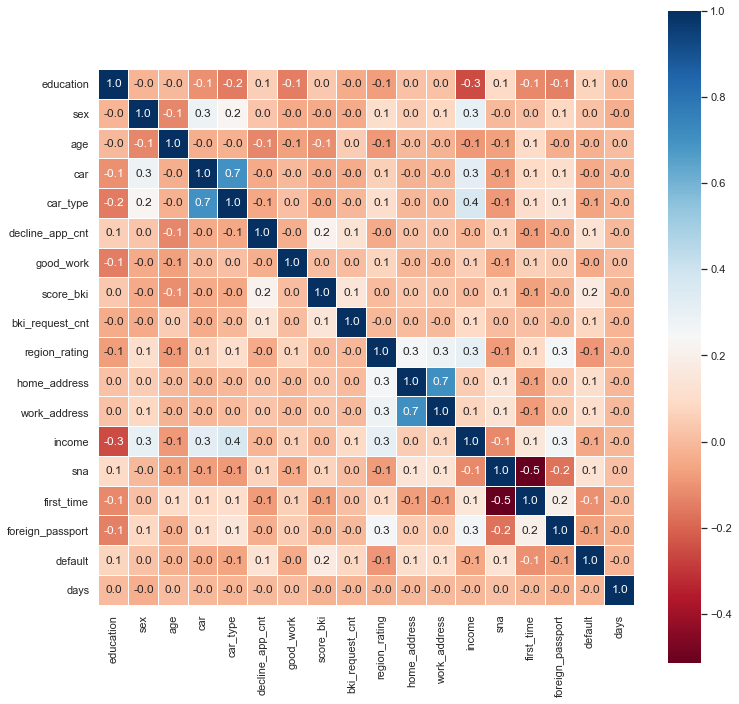

In [586]:
sns.set(font_scale = 1)
plt.subplots(figsize = (12,12))
sns.heatmap(df.query('days<90').drop(['Train', 'client_id'], axis = 1).corr(),square = True, annot = True, fmt = '.1f', linewidths=0.1, cmap="RdBu")

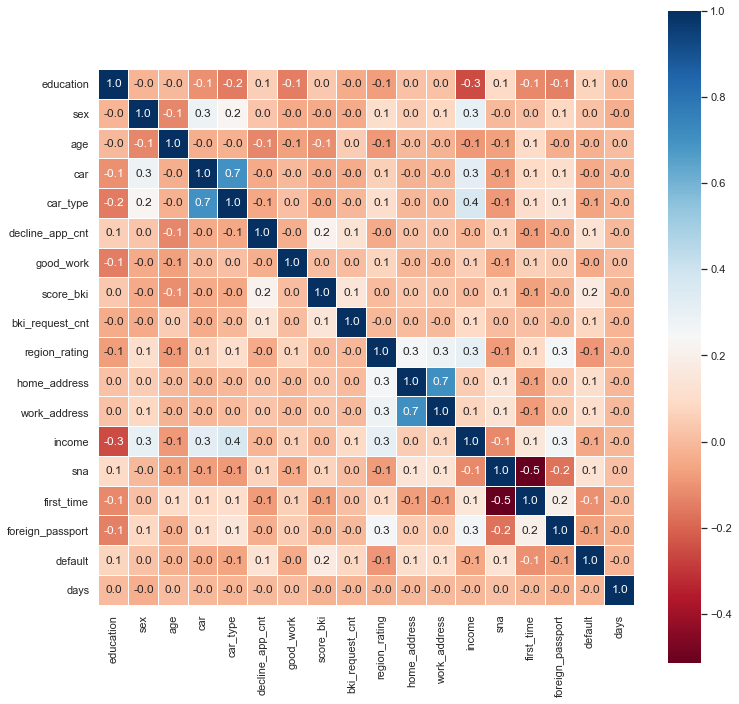

In [587]:
sns.set(font_scale = 1)
plt.subplots(figsize = (12,12))
sns.heatmap(df.query('days<90').drop(['Train', 'client_id'], axis = 1).corr(),square = True, annot = True, fmt = '.1f', linewidths=0.1, cmap="RdBu")

In [666]:
df[['car','car_type']].head(50)

,car,car_type
0,1,1
1,0,0
2,1,0
3,0,0
4,0,0
5,1,0
6,0,0
7,0,0
8,1,0
9,0,0


In [672]:
df[['car','car_type']].head(50)

,car,car_type
0,2,1
1,0,0
2,1,0
3,0,0
4,0,0
5,1,0
6,0,0
7,0,0
8,1,0
9,0,0
